In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
# !pip uninstall numpy
# !pip install numpy
!pip install pomegranate

     |████████████████████████████████| 17.9MB 1.2MB/s 
     |████████████████████████████████| 15.3MB 320kB/s 
ERROR: tensorflow 2.4.1 has requirement numpy~=1.19.2, but you'll have numpy 1.20.2 which is incompatible.
ERROR: datascience 0.10.6 has requirement folium==0.2.1, but you'll have folium 0.8.3 which is incompatible.
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.
  Found existing installation: numpy 1.19.5
    Uninstalling numpy-1.19.5:
      Successfully uninstalled numpy-1.19.5


In [1]:
from pomegranate import State, HiddenMarkovModel, DiscreteDistribution
from collections import Counter, defaultdict
import random
import numpy as np
import matplotlib.pyplot as plt


# #Preprocess Data

In [ ]:
files_all = ["guj_art and culture_sample1.txt", "guj_economy_sample2.txt", "guj_entertainment_sample3.txt", "guj_philosophy_sample4.txt", "guj_religion_sample5.txt", "guj_science and technology_sample6.txt", "guj_sports_sample7.txt"]
path = "/content/drive/MyDrive/Sem 4/NLP/Project/dataset/" + files_all[6]
filename = path.split('/')[-1]
file = open(path, "r")

contents = file.read().split('\n')
word_sentances = []
tag_sentances = []
for i in range(1,len(contents)):
  s = contents[i].split('\t')[1]
  words = []
  tags = []
  for ss in s.split(' '):
    if len(ss.split('\\')) != 2:
      continue
    word = ss.split('\\')[0]
    tag = ss.split('\\')[1]
    words.append(word)
    tags.append(tag)
  word_sentances.append(words)
  tag_sentances.append(tags)
  
file.close()

# # Create Aggregate Dataset

In [2]:
files_all = ["guj_art and culture_sample1.txt", "guj_economy_sample2.txt", "guj_entertainment_sample3.txt", "guj_philosophy_sample4.txt", "guj_religion_sample5.txt", "guj_science and technology_sample6.txt", "guj_sports_sample7.txt"]
word_sentances = []
tag_sentances = []

filename = "Aggregate"
for i in range(len(files_all)):
  path = "/content/drive/MyDrive/Sem 4/NLP/Project/dataset/" + files_all[i]
  filename = path.split('/')[-1]
  file = open(path, "r")

  contents = file.read().split('\n')
  for i in range(1,len(contents)):
    s = contents[i].split('\t')[1]
    words = []
    tags = []
    for ss in s.split(' '):
      if len(ss.split('\\')) != 2:
        continue
      word = ss.split('\\')[0]
      tag = ss.split('\\')[1]
      words.append(word)
      tags.append(tag)
    word_sentances.append(words)
    tag_sentances.append(tags)
  
file.close()

In [3]:
class_names = list(set([tag for sent in tag_sentances for tag in sent]))

# # Split into Train and Test

In [4]:
indexlist = random.sample(range(0, len(word_sentances)), int(len(word_sentances)*0.2))

word_sentances_test = []
tag_sentances_test = []
word_sentances_train = []
tag_sentances_train = []

for i in range(len(word_sentances)):
  if i in indexlist:
    word_sentances_test.append(word_sentances[i])
    tag_sentances_test.append(tag_sentances[i])
  else:
    word_sentances_train.append(word_sentances[i])
    tag_sentances_train.append(tag_sentances[i])
# word_sentances_train, word_sentances_test, tag_sentances_train, tag_sentances_test = train_test_split(word_sentances, tag_sentances, test_size=0.20, random_state=42)

In [ ]:
# trainItems = [item for sublist in word_sentances_train for item in sublist]
# testItems = [item for sublist in word_sentances_test for item in sublist]
# itemsTrainTest = set(testItems).intersection(set(trainItems))
# import pylab as plt
# from matplotlib_venn import venn2, venn3_circles
# v= venn2(subsets=(len(trainItems),len(itemsTrainTest),len(testItems)), set_labels = ('Train Dataset','Test Dataset'))
# v.get_patch_by_id('10').set_color('darkred')
# v.get_patch_by_id('01').set_color('yellow')
# v.get_patch_by_id('11').set_color('darkblue')

# # Handle Unknown Word

In [5]:
def getMinFreqWord(sentances):
  freq = defaultdict(int)
  for sent in sentances:
    for word in  sent:
      freq[word] += 1
  minfreq = 10000000000
  minword = None
  for word,count in freq.items():
    if count < minfreq:
      minfreq = count
      minword = word
  return minword, freq

minFreqWord, freq = getMinFreqWord(word_sentances_train)

# # HMM Model

In [6]:
def createEmissionTable(word_sentances,tag_sentances):
  emission = defaultdict(lambda: defaultdict(int))
  for word_sent,tag_sent in zip(word_sentances,tag_sentances):
    for word,tag in zip(word_sent,tag_sent):
      emission[tag][word] += 1
  return emission

def createTransitionTable(tag_sentances):
  transition = defaultdict(lambda: defaultdict(int))
  for tag_sent in tag_sentances:
    tag_sent = ['<s>'] + tag_sent + ['<e>']
    for i in range(len(tag_sent)-1):
        transition[tag_sent[i]][tag_sent[i+1]] += 1
  return transition

def addStates(hmm, emission, transition):

  #add states to HMM model
  hmm_state_dict = {}
  for tag,word_dict in emission.items():
    total = float(sum(word_dict.values()))
    arg_word_dict = {}
    for word,word_count in word_dict.items():
      arg_word_dict[word] = word_count/total
    state = State(DiscreteDistribution(arg_word_dict), name=tag)
    hmm_state_dict[tag] = state
    hmm.add_state(state)

  hmm_state_dict['<s>'] = hmm.start
  hmm_state_dict['<e>'] = hmm.end

  #add transition to HMM model
  transition_prob = defaultdict(lambda: defaultdict(int))
  for tag1,tag2dict in transition.items():
    total = sum(tag2dict.values())
    for tag2, count in tag2dict.items():
      transition_prob[tag1][tag2] = count/total
  
  for tag1,tag2dict in transition.items():
    for tag2, count in tag2dict.items():
        hmm.add_transition(hmm_state_dict[tag1], hmm_state_dict[tag2], transition_prob[tag1][tag2])
        
  hmm.bake()    


def createHMM(word_sentances, tag_sentances):
  hmm = HiddenMarkovModel(name="base-hmm-tagger")
  emission = createEmissionTable(word_sentances_train, tag_sentances_train)
  transition = createTransitionTable(tag_sentances_train)
  addStates(hmm, emission, transition)
  return hmm

hmm = createHMM(word_sentances_train, tag_sentances_train)

# # Evaluation Matrix

In [7]:
y_pred = []
y_true = []
def accuracy(X, Y, hmm):
    
    correct_prediction = wrong_prediction = total_predictions = total_word = 0
    passed = 0

    for sentance, actual_tags in zip(X, Y):
        try:
            for i in range(len(sentance)):              
              if freq[sentance[i]] == 0 :
                sentance[i] = minFreqWord

            _, state_path = hmm.viterbi(sentance)
            predicted_tags = [state[1].name for state in state_path[1:-1]]
            for pred, actual in zip(predicted_tags, actual_tags):
              y_pred.append(pred)
              y_true.append(actual)
              if pred == actual:
                correct_prediction += 1
              else:
                wrong_prediction += 1
              total_word += 1 
    
        except:
            passed += 1
            
        total_predictions += len(sentance)
    print(total_predictions,total_word)
    return correct_prediction / total_word

# print('Train data ',accuracy(word_sentances_train,tag_sentances_train, hmm))
print('Test data ',accuracy(word_sentances_test,tag_sentances_test, hmm))

19481 19346
Test data  0.8904683138633309


# # Analysis

In [9]:
from sklearn.metrics import classification_report
op = (classification_report(y_true, y_pred, output_dict=True))
op['accuracy']
from sklearn.metrics import classification_report
import pickle
def save_obj(obj, name ):
    with open('/content/drive/MyDrive/Sem 4/NLP/Project/output/'+ name + '.pkl', 'ab') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)
        f.close()

def load_obj(name ):
    with open('/content/drive/MyDrive/Sem 4/NLP/Project/output/' + name + '.pkl', 'rb') as f:  
      objs = []
      while 1:
          try:
              x = pickle.load(f)
              objs.append(x)
              for filename in x.keys():
                print(filename, x[filename]['accuracy'],x[filename]['weighted avg'])
          except EOFError:
              break
      
      return objs

report = (classification_report(y_true, y_pred,output_dict=True))
output = {}
output[filename] = report

save_obj(output, 'HMM_report')

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Confusion matrix, without normalization


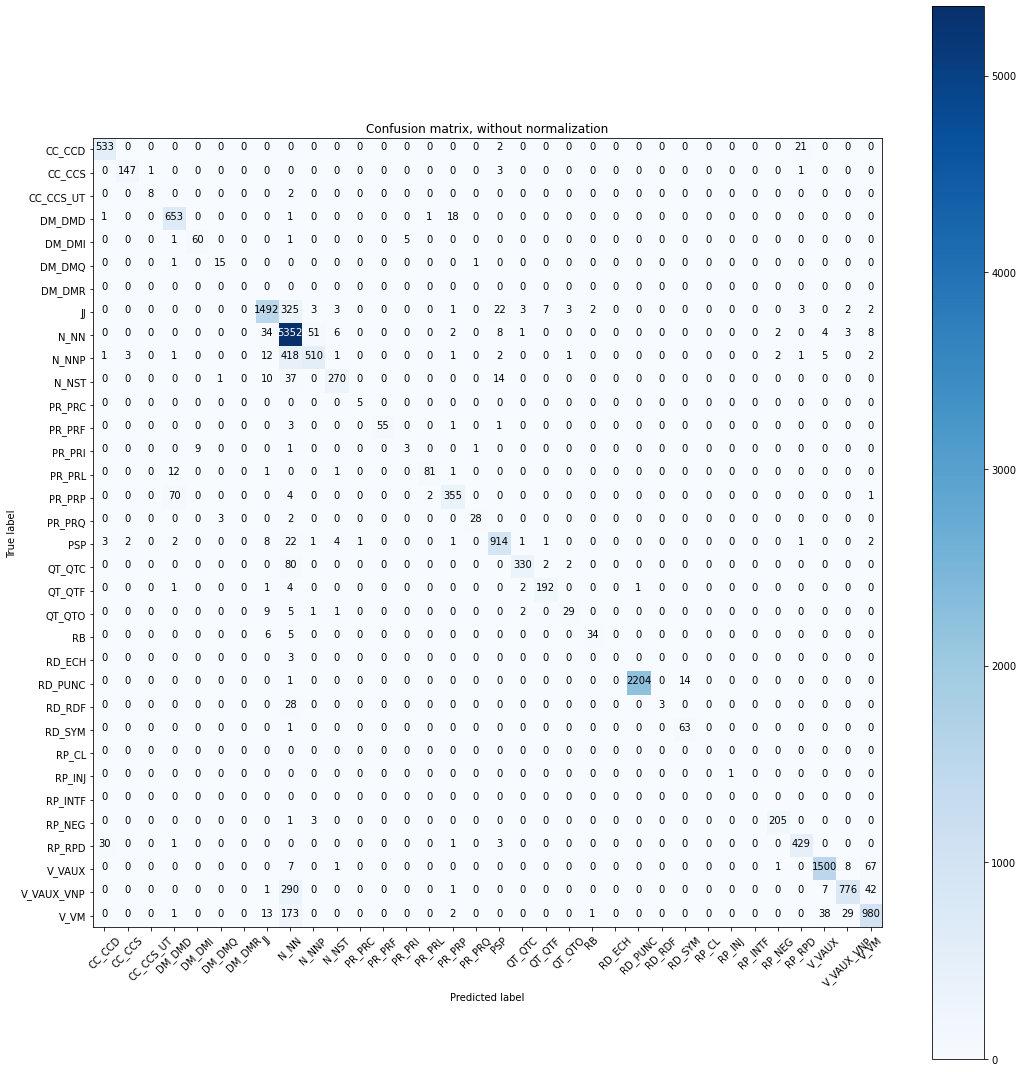

In [11]:
import itertools
import numpy as np
import matplotlib.pyplot as plt

from sklearn import svm, datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix


def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    # plt.figure(figsize=(25, 25))
    np.set_printoptions(precision=2)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Compute confusion matrix
class_names = sorted(class_names)

cnf_matrix = confusion_matrix(y_true, y_pred,labels=class_names)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plt.rcParams["figure.figsize"] = (15,15)
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
# plt.figure()
# plt.rcParams["figure.figsize"] = (15,15)
# plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
#                       title='Normalized confusion matrix')

# plt.show()

#Parts of Speech Tagset: Gujarati
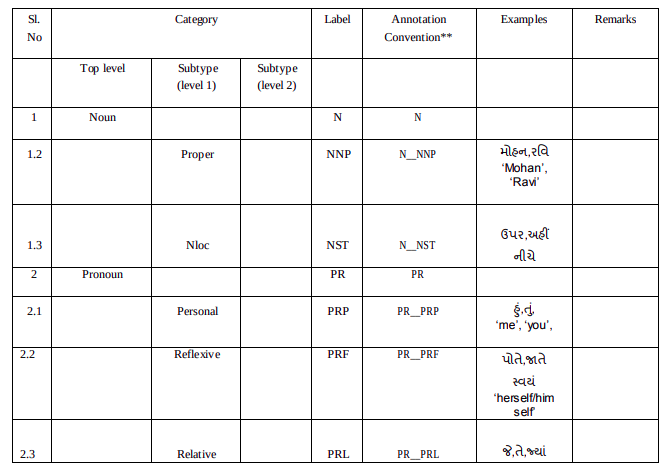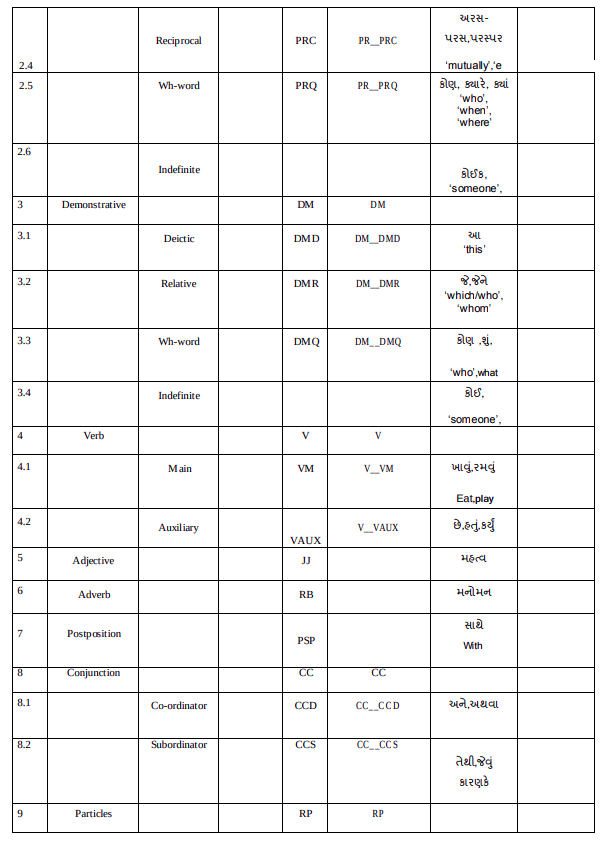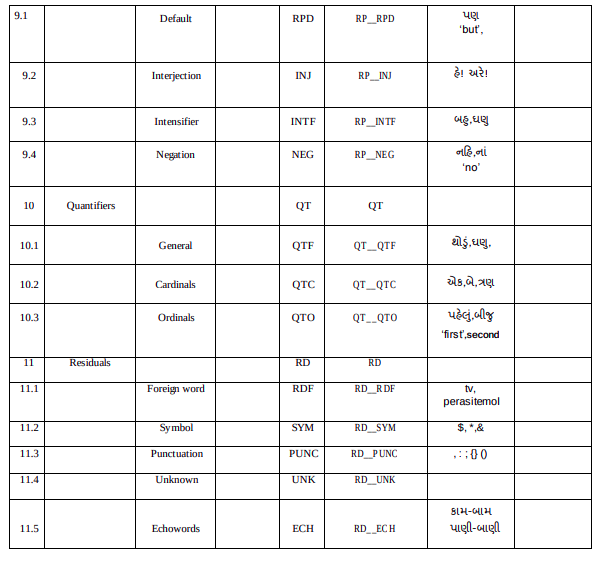

# # Result

| Dataset | Train Data Accuracy | Test Data Accuracy |
| --- | --- | --- |
| guj_art and culture_sample1.txt | 0.9801 | 0.7413 |
| guj_economy_sample2.txt | 0.9884 | 0.9061 |
| guj_entertainment_sample3.txt | 0.9716 | 0.7680 |
| guj_philosophy_sample4.txt | 0.9866 | 0.8674 |
| guj_religion_sample5.txt | 0.9770 | 0.7100 |
| guj_science and technology_sample6.txt | 0.9810 | 0.8532 |
| guj_sports_sample7.txt | 0.9753 | 0.7824 |

# HMM Model

Example sentances
*  Mary Jane can see Will 
*  Spot will see Mary
*  Will Jane spot Mary?
*  Mary will pat Spot

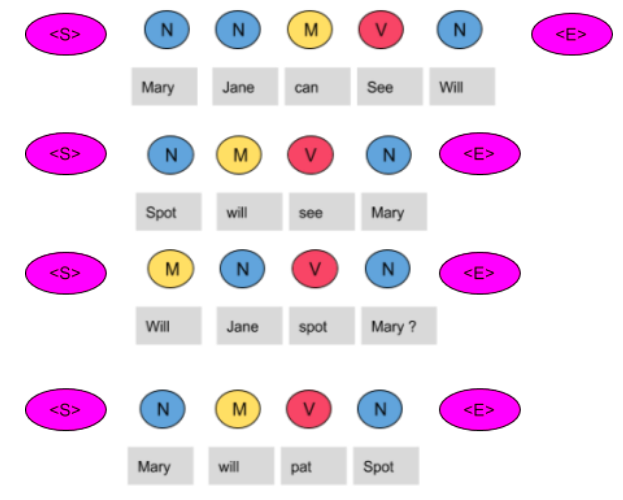
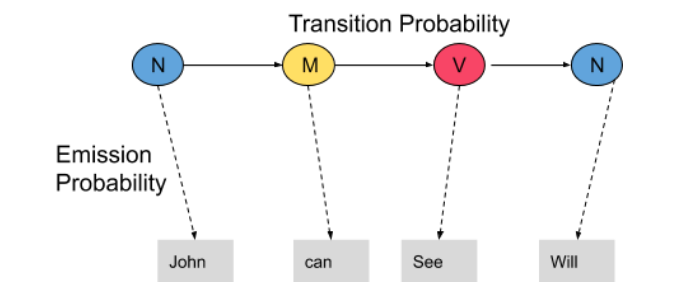


##Transition Table
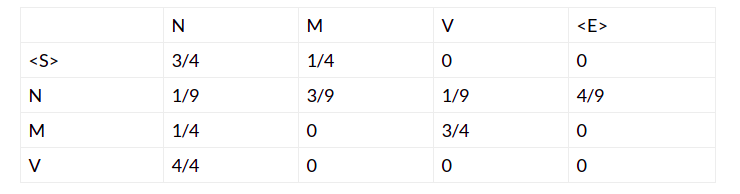


##Emission Table
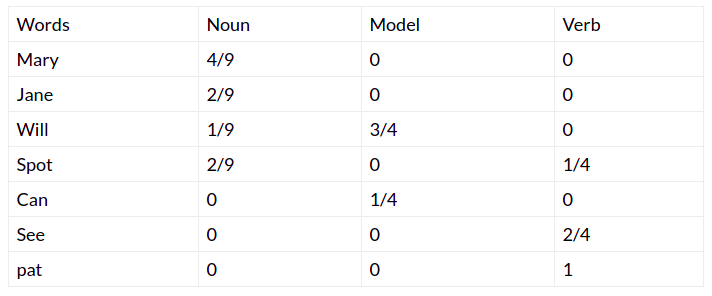

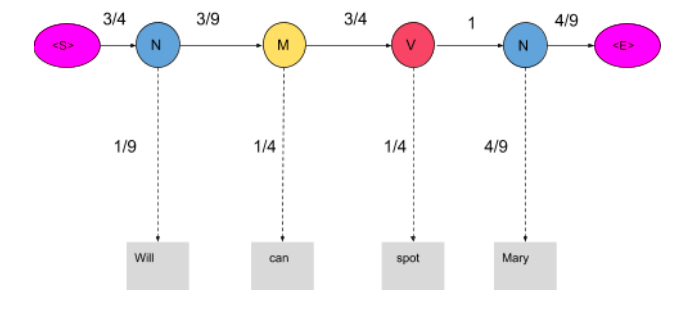
<br>
As given above we can generate every possible sequence of hidden states and find one with maximum probability which is very expensive. solution is Viterbi Algorithm.